In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for plots
sns.set_style('whitegrid')

# --- Load the datasets using relative paths ---
# We use '../' to go up from the 'notebooks' folder to the main project folder
try:
    trades_df = pd.read_csv('../data/raw/historical_data.csv')
    sentiment_df = pd.read_csv('../data/raw/fear_greed_index.csv')
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please make sure your files are in the 'data/raw' directory and the names are correct.")

# Display the first few rows and basic info to confirm
print("--- Trader Data ---")
print(trades_df.head())

print("\n--- Market Sentiment Data ---")
print(sentiment_df.head())

print("\n--- Trader Data Info ---")
trades_df.info()

--- Trader Data ---
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0  

In [2]:
# --- Part A: Convert Time and Date Columns ---

# Check if 'datetime' column already exists to prevent re-running errors
if 'datetime' not in trades_df.columns:
    print("Creating 'datetime' column in trades_df...")
    # Convert the 'Timestamp' column in trades_df from milliseconds
    trades_df['datetime'] = pd.to_datetime(trades_df['Timestamp'], unit='ms')

# Check if the 'date' column still exists in sentiment_df
if 'date' in sentiment_df.columns:
    print("Converting 'date' column in sentiment_df...")
    # Convert the 'date' column to a datetime object
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])


# --- Part B: Create a Common Merge Key ---

# Check if 'trade_date' column already exists in trades_df
if 'trade_date' not in trades_df.columns:
    print("Creating 'trade_date' column in trades_df...")
    # Create a new 'trade_date' column by normalizing the 'datetime' column
    trades_df['trade_date'] = trades_df['datetime'].dt.normalize()

# Rename 'date' to 'trade_date' in sentiment_df only if 'date' still exists
if 'date' in sentiment_df.columns:
    print("Renaming 'date' to 'trade_date' in sentiment_df...")
    sentiment_df.rename(columns={'date': 'trade_date'}, inplace=True)


# --- Part C: Perform the Merge ---
print("Merging the two DataFrames...")
# This merge will now work correctly every time
merged_df = pd.merge(trades_df, sentiment_df, on='trade_date', how='left')


# --- Part D: Verify the Result ---

print("\n--- Merge Successful! ---")
print("New 'merged_df' Info:")
merged_df.info()

print("\n--- First 5 rows of the combined data (Corrected) ---")
# Using the correct lowercase 'classification' column name
print(merged_df[['datetime', 'trade_date', 'Coin', 'Closed PnL', 'classification']].head())

Creating 'datetime' column in trades_df...
Converting 'date' column in sentiment_df...
Creating 'trade_date' column in trades_df...
Renaming 'date' to 'trade_date' in sentiment_df...
Merging the two DataFrames...

--- Merge Successful! ---
New 'merged_df' Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Account           211224 non-null  object        
 1   Coin              211224 non-null  object        
 2   Execution Price   211224 non-null  float64       
 3   Size Tokens       211224 non-null  float64       
 4   Size USD          211224 non-null  float64       
 5   Side              211224 non-null  object        
 6   Timestamp IST     211224 non-null  object        
 7   Start Position    211224 non-null  float64       
 8   Direction         211224 non-null  object        
 9   Closed PnL       

Missing sentiment values: 26961


C:\Users\dspgy\AppData\Local\Temp\ipykernel_33796\3793329129.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='classification', order=merged_df['classification'].value_counts().index, palette='viridis')


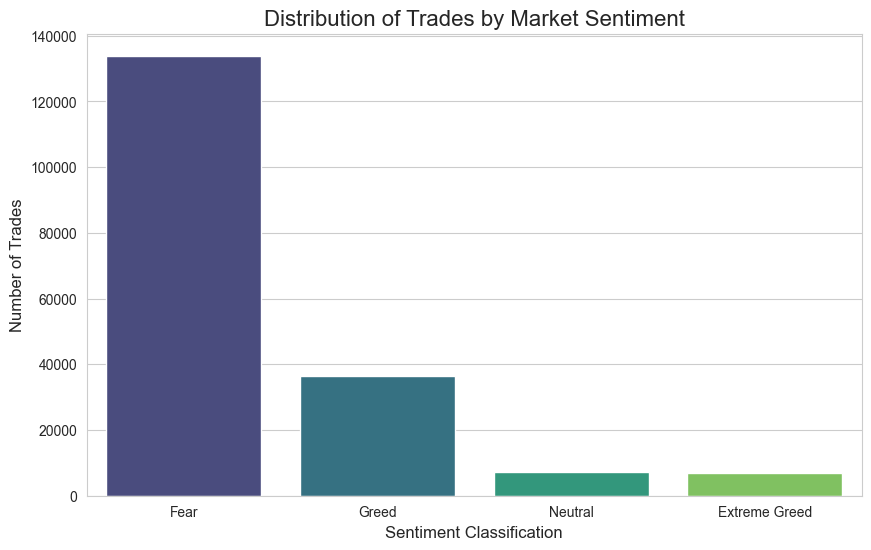

In [3]:
# --- Analysis 1: Distribution of Market Sentiment ---

# Let's check for any missing sentiment data first
print(f"Missing sentiment values: {merged_df['classification'].isnull().sum()}")

# Create a figure with a specific size for better readability
plt.figure(figsize=(10, 6))

# Use seaborn's countplot to visualize the distribution
sns.countplot(data=merged_df, x='classification', order=merged_df['classification'].value_counts().index, palette='viridis')

plt.title('Distribution of Trades by Market Sentiment', fontsize=16)
plt.xlabel('Sentiment Classification', fontsize=12)
plt.ylabel('Number of Trades', fontsize=12)
plt.show()

--- Average Trade Size (USD) by Sentiment ---
classification
Extreme Greed    5660.265764
Fear             5259.977837
Greed            3182.883845
Neutral          3058.848110
Name: Size USD, dtype: float64


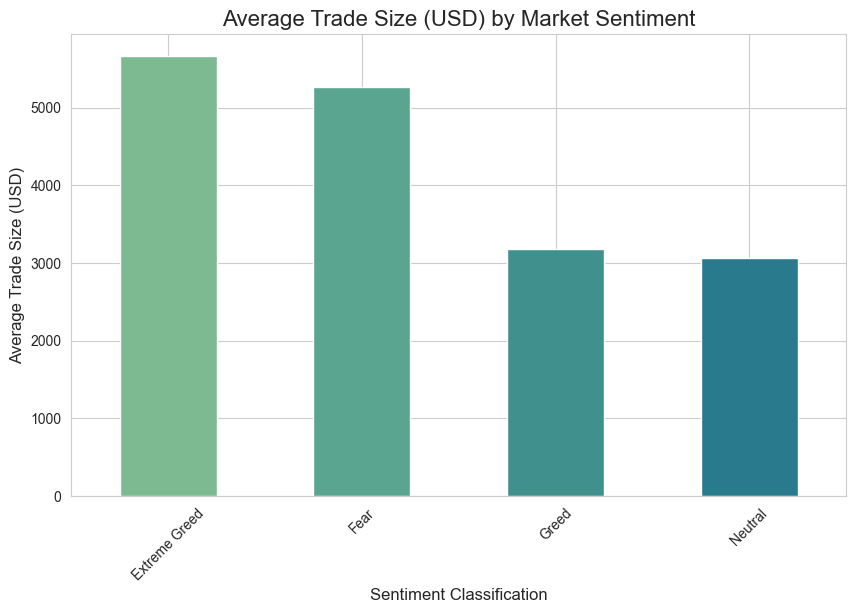

In [4]:
# --- Analysis 3: Average Trade Size (USD) per Sentiment Category ---

# Group by sentiment and calculate the mean of 'Size USD'
avg_size_by_sentiment = merged_df.groupby('classification')['Size USD'].mean().sort_values(ascending=False)

print("--- Average Trade Size (USD) by Sentiment ---")
print(avg_size_by_sentiment)

# Visualize the average trade size
plt.figure(figsize=(10, 6))
avg_size_by_sentiment.plot(kind='bar', color=sns.color_palette('crest'))

plt.title('Average Trade Size (USD) by Market Sentiment', fontsize=16)
plt.xlabel('Sentiment Classification', fontsize=12)
plt.ylabel('Average Trade Size (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.show()